<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [73]:
deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/deliveries.jsonl', lines=True)
sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/sessions.jsonl', lines=True)
products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/products.jsonl', lines=True)
users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/users.jsonl', lines=True)

In [74]:
deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
deliveries['delivery_day'] = deliveries['delivery_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))
deliveries['purchase_day'] = deliveries['purchase_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
deliveries['diff_days'] = (deliveries['delivery_day'] - deliveries['purchase_day']).apply(lambda x: x.days)
#deliveries['purchase_hour'] = deliveries['purchase_timestamp'].apply(lambda x: x.hour)
deliveries['purchase_morning'] = deliveries['purchase_timestamp'].apply(lambda x: 1 if x.hour<=14 else 0)

In [75]:
all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
all_info = all_info.merge(users, on='user_id', how='left')

In [76]:
all_info

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,delivery_day,purchase_day,diff_days,purchase_morning,session_id,timestamp,user_id,product_id,event_type,offered_discount,product_name,category_path,price,name,city,street
0,20001,2020-10-20 13:00:31,2020-10-23 08:10:14.269281,516,2020-10-23,2020-10-20,3,1,124,2020-10-20 13:00:31,102,1067,BUY_PRODUCT,0,Nokia 3310,Telefony i akcesoria;Telefony komórkowe,207.33,Hubert Rybus,Warszawa,aleja Popiełuszki 640
1,20002,2021-11-01 16:12:47,2021-11-03 16:54:19.834601,254,2021-11-03,2021-11-01,2,0,127,2021-11-01 16:12:47,102,1001,BUY_PRODUCT,15,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,Hubert Rybus,Warszawa,aleja Popiełuszki 640
2,20003,2020-03-06 22:46:45,2020-03-09 16:00:20.290406,516,2020-03-09,2020-03-06,3,0,128,2020-03-06 22:46:45,102,1013,BUY_PRODUCT,0,LA Noire (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,129.99,Hubert Rybus,Warszawa,aleja Popiełuszki 640
3,20004,2021-02-24 13:03:01,2021-02-26 16:28:43.495509,360,2021-02-26,2021-02-24,2,1,129,2021-02-24 13:03:01,102,1291,BUY_PRODUCT,15,Philips SDV6224,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,168.79,Hubert Rybus,Warszawa,aleja Popiełuszki 640
4,20005,2021-02-01 13:27:28,2021-02-04 08:52:32.414187,516,2021-02-04,2021-02-01,3,1,130,2021-02-01 13:27:28,102,1055,BUY_PRODUCT,20,Call of Duty Modern Warfare 3 (PC),Gry i konsole;Gry komputerowe,32.99,Hubert Rybus,Warszawa,aleja Popiełuszki 640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13755,33756,2021-05-07 09:24:25,2021-05-10 08:23:11.320381,516,2021-05-10,2021-05-07,3,1,19802,2021-05-07 09:24:25,350,1277,BUY_PRODUCT,0,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02,Apolonia Rudzik,Szczecin,ulica Głowackiego 75/57
13756,33757,2021-02-18 07:25:19,2021-02-20 08:16:48.837576,620,2021-02-20,2021-02-18,2,1,19803,2021-02-18 07:25:19,350,1318,BUY_PRODUCT,0,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00,Apolonia Rudzik,Szczecin,ulica Głowackiego 75/57
13757,33758,2020-07-22 20:11:13,2020-07-25 08:29:22.016324,620,2020-07-25,2020-07-22,3,0,19805,2020-07-22 20:11:13,350,1315,BUY_PRODUCT,10,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99,Apolonia Rudzik,Szczecin,ulica Głowackiego 75/57
13758,33759,2021-02-23 01:45:12,2021-02-25 08:42:51.007068,620,2021-02-25,2021-02-23,2,1,19808,2021-02-23 01:45:12,351,1317,BUY_PRODUCT,0,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96,Bruno Kapinos,Gdynia,al. Zbożowa 276


In [77]:
dec_var = ["delivery_company", 'diff_days', 'purchase_morning', 'city']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


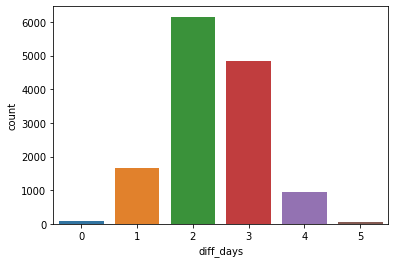

In [78]:
sns.countplot(all_info['diff_days'])

In [79]:
all_info[dec_var]

,delivery_company,diff_days,purchase_morning,city
0,516,3,1,Warszawa
1,254,2,0,Warszawa
2,516,3,0,Warszawa
3,360,2,1,Warszawa
4,516,3,1,Warszawa
...,...,...,...,...
13755,516,3,1,Szczecin
13756,620,2,1,Szczecin
13757,620,3,0,Szczecin
13758,620,2,1,Gdynia


In [80]:
all_info = all_info.drop(all_info.index[all_info['diff_days'].isin([0,5])], axis=0)

In [81]:
all_info = all_info[dec_var]

In [82]:
city_dum = pd.get_dummies(all_info['city'], drop_first=True)

In [83]:
delivery_company_dum = pd.get_dummies(all_info['city'], drop_first=True)

In [84]:
all_info.drop('delivery_company', axis=1, inplace=True)

In [85]:
all_info.drop('city', axis=1, inplace=True)

In [86]:
final = pd.concat([all_info, city_dum, delivery_company_dum], axis=1)

In [88]:
X = final.drop('diff_days', axis=1)

In [89]:
y = final['diff_days']

## **Logistic Regression**

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [106]:
model = LogisticRegression()

In [107]:
model.fit(X_train, y_train)

LogisticRegression()

In [108]:
accuracy_score(y_test, model.predict(X_test))

0.5869806709620085

In [109]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.70      0.53      0.60       556
           2       0.60      0.65      0.63      2028
           3       0.54      0.64      0.59      1611
           4       0.00      0.00      0.00       306

    accuracy                           0.59      4501
   macro avg       0.46      0.45      0.45      4501
weighted avg       0.55      0.59      0.57      4501



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **SVM**

In [110]:
from sklearn.svm import SVC

In [111]:
mod_svm = SVC(kernel='linear')

In [112]:
mod_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [113]:
accuracy_score(y_test, mod_svm.predict(X_test))

0.579871139746723

In [114]:
print(classification_report(y_test, mod_svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.70      0.53      0.60       556
           2       0.57      0.72      0.64      2028
           3       0.56      0.53      0.54      1611
           4       0.00      0.00      0.00       306

    accuracy                           0.58      4501
   macro avg       0.46      0.45      0.45      4501
weighted avg       0.54      0.58      0.56      4501



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **KNN**

In [115]:
from sklearn.neighbors import KNeighborsClassifier

In [118]:
neigh = KNeighborsClassifier(n_neighbors = 3)

In [119]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [120]:
print(classification_report(y_test, neigh.predict(X_test)))

              precision    recall  f1-score   support

           1       0.39      0.63      0.48       556
           2       0.54      0.52      0.53      2028
           3       0.50      0.51      0.51      1611
           4       0.00      0.00      0.00       306

    accuracy                           0.50      4501
   macro avg       0.36      0.42      0.38      4501
weighted avg       0.47      0.50      0.48      4501



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
